In [1]:
import pydicom
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

> pydicom
https://pyscience.wordpress.com/2014/09/08/dicom-in-python-importing-medical-image-data-into-numpy-with-pydicom-and-vtk/

http://scikit-image.org/docs/dev/auto_examples/

todolist
get bone window 800-2000
learn


> Get Dicom File List

In [2]:
from os import walk
PathDicom = 'MRCT/DICOM/CT L1-L5 (1mm)/S3010/'
lstFilesDCM = []
# get all file name in a directory
for (dirpath, dirnames, filenames) in walk(PathDicom):
    lstFilesDCM.extend(filenames)
    break
for i in range(len(lstFilesDCM)):
    lstFilesDCM[i] = PathDicom + lstFilesDCM[i]
#print(lstFilesDCM)

> Get Dicom Ref

In [3]:
# Get ref file
RefDs = pydicom.read_file(lstFilesDCM[0])
# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))
print (ConstPixelDims)
# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))
print (ConstPixelSpacing)

(512, 512, 341)
(0.4375, 0.4375, 1.0)


> Dicom -> Array

In [4]:
# The array is sized based on 'ConstPixelDims'
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # read the file
    ds = pydicom.read_file(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array  

range:  2720  ( 0 ~ 2720 )
range:  1200  ( 800 ~ 2000 )


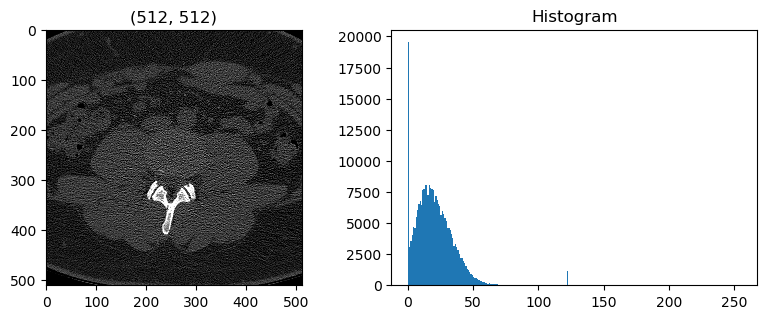

In [5]:
num = 50
DicomImg = ArrayDicom[:, :, num]

#print (DicomImg, np.dtype(DicomImg[0][0]))
print ('range: ',np.ptp(DicomImg),' (' , np.min(DicomImg),'~' , np.max(DicomImg), ')')

plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')

# filter grayscale 800~2000
gray_filtered = np.clip(DicomImg,800,2000)
print ('range: ',np.ptp(gray_filtered),' (' , np.min(gray_filtered),'~' , np.max(gray_filtered), ')')

DicomImg_norm = (gray_filtered - 800) / 2500 * 255
plt.subplot(221), plt.title(DicomImg.shape), plt.imshow(gray_filtered, cmap='gray')

# uint16 uint8
DicomImg_norm = DicomImg_norm.astype(np.uint8)
#print (DicomImg_norm, np.dtype(DicomImg_norm[0][0]))
#plt.subplot(222), plt.title('Histogram'), plt.hist(DicomImg_norm.ravel(),255,[0,255])
plt.subplot(222), plt.title('Histogram'), plt.hist(DicomImg_norm.ravel(),255,[0,255])
plt.tight_layout()
plt.show()

In [88]:
import shutil #use to delete dir
directory = 'CT_IP_2_output/'
shutil.rmtree(directory, ignore_errors=True)# delete dir
if not os.path.exists(directory):
    os.makedirs(directory)

def CT_IP(DicomImg, show, out,num_list):
    
    for num in range(ArrayDicom.shape[2]):# num_list, range(ArrayDicom.shape[2])
        DicomImg = ArrayDicom[:, :, num]
        
        # filter grayscale 800~2000
        gray_filtered = np.clip(DicomImg,800,2000)
        
        # Normalised [0,255]
        DicomImg_norm = (gray_filtered - 800) / 2500 * 255
        
        # uint16 uint8
        DicomImg_norm = DicomImg_norm.astype(np.uint8)
        
        # Cut
        DicomImgCut = DicomImg_norm[150:480, 0:512]
        
        # Histograms Equalization
        DicomImgCut_HE = cv2.equalizeHist(DicomImgCut)
        
        # GaussianBlur
        DicomImgCut_G = cv2.GaussianBlur(DicomImgCut_HE,(7,7),0,0)
        
        # Threshold
        Threshold = 180
        DicomImgCut_T = (DicomImgCut_G > Threshold) * 255
        DicomImgCut_T = DicomImgCut_T.astype(np.uint8)
        # Threshold Otsu
        #gray_filtered2 = np.clip(DicomImgCut_G,170,255)
        #DicomImgCut_T = cv2.threshold(gray_filtered2,150,230,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        #Threshold = DicomImgCut_T[0]
        
        # MedianBlur
        DicomImgCut_MED = cv2.medianBlur(DicomImgCut_T, 7)
        
        # Sobel
        sobelx = cv2.Sobel(DicomImgCut_MED,cv2.CV_64F,1,0,ksize=3)  # x
        sobely = cv2.Sobel(DicomImgCut_MED,cv2.CV_64F,0,1,ksize=3)  # y
        absX = cv2.convertScaleAbs(sobelx) 
        absY = cv2.convertScaleAbs(sobely)
        DicomImgCut_S = cv2.addWeighted(absX,1,absY,1,0)
        
        # Mask
        DicomImgCut_mask = cv2.bitwise_and(DicomImgCut,DicomImgCut,mask = DicomImgCut_MED)
        
        # show detail
        if show == 1:
            plt.figure(num=None, figsize=(8, 15), dpi=100, facecolor='w', edgecolor='k')
            plt.subplot(5,2,1), plt.title('Origin'), plt.imshow(DicomImg_norm, cmap='gray')
            plt.subplot(5,2,2), plt.title('Cut'), plt.imshow(DicomImgCut, cmap='gray')
            plt.subplot(5,2,3), plt.title('equalizeHist'), plt.imshow(DicomImgCut_HE, cmap='gray')   
            plt.subplot(5,2,4), plt.title('GaussianBlur'), plt.imshow(DicomImgCut_G, cmap='gray')
            plt.subplot(5,2,5), plt.title('Histogram of G'), plt.hist(DicomImgCut_G.ravel(),256,[0,256])
            plt.subplot(5,2,6), plt.title('Threshold '+str(Threshold)), plt.imshow(DicomImgCut_T, cmap='gray')      
            plt.subplot(5,2,7), plt.title('Median'), plt.imshow(DicomImgCut_MED, cmap='gray')  
            plt.subplot(5,2,8), plt.title('Sobel'), plt.imshow(DicomImgCut_S, cmap='gray')
            plt.subplot(5,2,9), plt.title('Mask'), plt.imshow(DicomImgCut_mask, cmap='gray')
            x,y = np.argwhere(DicomImgCut_S == 255).T
            plt.subplot(5,2,10), plt.title('Result'), plt.imshow(DicomImgCut, cmap='gray')
            plt.scatter(y, x, marker='.', c='r', s=0.01)
            plt.tight_layout()
            plt.show()
        elif show == 2:
            plt.figure(num=None, figsize=(12, 15), dpi=100, facecolor='w', edgecolor='k')
            plt.subplot(141), plt.title(str(num)+': Origin'), plt.imshow(DicomImgCut, cmap='gray')
            x,y = np.argwhere(DicomImgCut_S == 255).T
            plt.subplot(142), plt.title(str(num)+': Result'), plt.imshow(DicomImgCut, cmap='gray')
            plt.scatter(y, x, marker='.', c='r', s=0.01)
            plt.subplot(143), plt.title('Mask'), plt.imshow(DicomImgCut_mask, cmap='gray')
            plt.subplot(144), plt.title('Shape'), plt.imshow(DicomImgCut_MED, cmap='gray') 
            plt.tight_layout()
            plt.show()
        elif show == 3:
            print (num)
            
        # output image
        if out == True:
            cv2.imwrite('CT_IP_2_output/'+str(num)+'_x.png',DicomImgCut)
            cv2.imwrite('CT_IP_2_output/'+str(num)+'_y.png',DicomImgCut_MED)
            
            
l1 = [2]
l2 = [1,5,10,20,30,40,50,75,100,150,175,200,300]
CT_IP(DicomImg, 3, True, l1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [84]:
print (ArrayDicom.shape[2])

341
